In [1]:
import pandas as pd
from os.path import join, basename
from glob import glob
from scipy.stats import spearmanr
import numpy as np


from sklearn.metrics import mean_absolute_error
''''
SpeechFormer
'''
GROUP_BY_DATE = False
GROUP_SEPARATOR = "_"
PATIENT_GROUP_LOCATION_IN_FILENAME = 1
ID_LOCATION_IN_FILENAME = -4

SUBKLINISCHE_GRUPPE = "SubklinischeGruppe"
TRUE = "true"
''''
    all recordings
'''
RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"
BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/speechformer_base/"
BASELINE_FOLDER = "all_recordings_feedback_experiment_e60_es15"
RESULT_FOLDER = "all_recordings_feedback_experiment_e60_es15_adapter_depression_tests"
''''

    answers only
'''
# RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"
# BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/speechformer_base/"
# BASELINE_FOLDER = "ema_e60_b32_lr0.0001_hubert12_updated"
# RESULT_FOLDER = "ema_e60_b32_lr0.0001_hubert12_updated"
''''
    neutral texts 
'''
''''
hyperformer all
'''
# GROUP_SEPARATOR = "/"
# GROUP_BY_DATE = True
# ID_LOCATION_IN_FILENAME = -2
# PATIENT_GROUP_LOCATION_IN_FILENAME = 4
# SUBKLINISCHE_GRUPPE = "Subklinische_Gruppe"
# TRUE = "selfRatingDepression"
''''
    meta data and neutral texts 
'''
# RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
# BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
# BASELINE_FOLDER = "wav2vec"
# RESULT_FOLDER = "gpu1/hyperformer++_all_meta_nt"
''''
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
#BASELINE_FOLDER = "wav2vec"
#RESULT_FOLDER = "hyperformer++_all_nt"
''''
    meta, nt, embedding
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
#BASELINE_FOLDER = "wav2vec"
#RESULT_FOLDER = "hyperformer++_all_nt_meta"


''''
hyperformer reapprasials
'''

#GROUP_BY_DATE = False
#PATIENT_GROUP_LOCATION_IN_FILENAME = 9
# ID_LOCATION_IN_FILENAME = -3

#SUBKLINISCHE_GRUPPE = "SubklinischeGruppe"
''''
    meta data 
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_FOLDER = "hyperformer++_reapprasial_depression"
#RESULT_FOLDER = "hyperformer++_reapprasial_meta_embedding"
''''
hyperformer reapprasials
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial"
#RESULT_FOLDER = "hyperformer++_reapprasial_nt"
''''
hyperformer reapprasials
    meta data and neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial_depression"
#RESULT_FOLDER = "hyperformer++_reapprasial_meta_embedding"



"'\nhyperformer reapprasials\n    meta data and neutral texts \n"

In [2]:
def load_predictions(experiment, patient_groups=None, result_base_adjusted=None):
    predictions = {}
    if result_base_adjusted is None: 
        current_result_base = RESULTS_BASE 
    else: 
        current_result_base = result_base_adjusted
    fold_dirs = glob(f"{current_result_base}/{experiment}/*/")
    for fold_dir in fold_dirs:
        try:
            fold = int(fold_dir.split("/")[-2])
            fold_predictions = list(glob(f"{fold_dir}/predictions.test.csv"))[0]
            _predictions = parse_filename(pd.read_csv(fold_predictions))
            if patient_groups is not None:
                _predictions = _predictions[_predictions["patientGroup"].isin(patient_groups)]
            if not "true" in _predictions.columns:
                _predictions["true"] = _predictions["selfRatingDepression"]
            predictions[fold] = _predictions
        except ValueError:
            print(f"{fold_dir} probably not a fold directory.")
    all_predictions = pd.concat(predictions.values())
    return predictions, all_predictions

def parse_filename(df):    
    #df["date"] = df["filename"].apply(lambda x: basename(x).split("_")[0])
    df["patientGroup"] = df["filename"].apply(lambda x: x.split("_")[PATIENT_GROUP_LOCATION_IN_FILENAME])
    df["ID"] = df["filename"].apply(lambda x: x.split("_")[PATIENT_GROUP_LOCATION_IN_FILENAME + 1])
   # df["Content"] = df["filename"].apply(lambda x: basename(x))
    return df

def session_mean(df):
    numeric_columns = ["true", "prediction"] 
    return df.groupby(["ID", "patientGroup"])[numeric_columns].mean().reset_index()

def compute_metrics(df, group_by=[]):
    
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    print(speaker_spearman)
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
    return speaker_spearman, grouped_speaker_spearman

     
def compute_metrics_2(df, group_by=[]):
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    mae = mean_absolute_error(df["true"], df["prediction"])
    
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
        grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolute_error(x["true"], x["prediction"])).dropna().groupby(group_by).mean()
        return speaker_spearman, grouped_speaker_spearman, mae, grouped_mae
    else:
        return speaker_spearman, mae



In [3]:
def print_metrics(metrics):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f} ({np.std(metrics[key]):.3f})"
    return metric_string + " \\\\"

def print_metrics_2(metrics, metrics_mae):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f}\(\pm\){np.std(metrics[key]):.3f} & {np.mean(metrics_mae[key]):.3f}\(\pm\){np.std(metrics_mae[key]):.3f}"
    return metric_string + " \\\\"
    
def general_metrics_2(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    metrics_mae = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        # predictions_mean = session_mean(predictions)
        speaker_rho, grouped_speaker_rho, mae, grouped_mae = compute_metrics_2(predictions, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        metrics_mae["All"].append(mae)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
        for name, value in zip(grouped_mae.index, grouped_mae.values):
            metrics_mae[name].append(value)
    return metrics, metrics_mae

def general_metrics(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        
        speaker_rho, grouped_speaker_rho = compute_metrics(predictions, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
        # predictions_mean = session_mean(predictions)
        # print(predictions_mean)
        # speaker_rho, grouped_speaker_rho = compute_metrics(predictions_mean, group_by=["patientGroup"])
        # metrics["All"].append(speaker_rho)
        # for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
        #     metrics[name].append(value)
    return metrics

def phrase_metrics(experiment):
    predictions_fold, predictions_all = load_predictions(experiment)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"] = []
            metrics["All"].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics

def type_metrics(experiment):
    predictions_fold, predictions_all = load_predictions(experiment)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        #predictions["Content"] = predictions["Content"].apply(lambda x: "Frage" if "Frage" in x else "Antwort" if "Antwort" in x else "positiverGedanke" if "positiverGedanke" in x else "Garbage")
        predictions = predictions.groupby(["ID", "date", "patientGroup"]).mean().reset_index()
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"] = []
            metrics["All"][content].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics
    

In [4]:
# m = type_metrics("hyperformer++_all")
# print(pd.DataFrame(data=m).to_latex())

import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
configs = [
    # ("Base", "all_recordings_feedback_experiment_e60_es15", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    ("Base", "all_recordings_feedback_experimente60_es15_", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    # ("Tests", "all_recordings_feedback_experiment_e60_es15_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    # ("NT", "all_recordings_feedback_experiment_e60_es15_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    # ("Embed", "all_recordings_feedback_experiment_e60_es15_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    # ("Tests\&Embed", "all_recordings_feedback_experiment_e60_es15_depression_tests_embedding", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    # ("Tests\&NT", "all_recordings_feedback_experiment_e60_es15_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    # ("Tests\&NT\&Embed", "all_recordings_feedback_experiment_e60_es15_depression_tests_nt_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
]

for name, folder, base in configs:
    print(name)

    m = type_metrics(experiment=folder, folder=base)
    print(pd.DataFrame(data=m).to_latex())


SpeechFormer++ Base


TypeError: type_metrics() got an unexpected keyword argument 'folder'

In [27]:
# m = type_metrics("hyperformer++_all")
# print(pd.DataFrame(data=m).to_latex())
m = type_metrics(RESULT_FOLDER)
print(pd.DataFrame(data=m).to_latex())



ValueError: No objects to concatenate

In [28]:
# m = phrase_metrics("hyperformer++_all")
m = phrase_metrics(RESULT_FOLDER)
print(pd.DataFrame(data=m).to_latex())

TypeError: unhashable type: 'list'

In [29]:
predictions = list(glob(join(RESULTS_BASE, RESULT_FOLDER, "**/*.csv")))
predictions_df = pd.concat([pd.read_csv(csv) for csv in predictions])
#predictions_df.to_csv("predictions_"+RESULT_FOLDER+"_hyperformer.csv", index=False)

                                               filename  prediction  true  \
0     Feedback_Kontrollgruppe_PM0860_Negative_stim=1...    1.384977   1.0   
1     Feedback_Kontrollgruppe_PM0860_Negative_stim=1...    1.233277   1.0   
2     Feedback_Kontrollgruppe_PM0860_Negative_stim=1...    1.214865   1.0   
3     Feedback_Kontrollgruppe_PM0860_Negative_stim=1...    1.641013   1.0   
4     Feedback_Kontrollgruppe_PM0860_Negative_stim=1...    1.580128   1.0   
...                                                 ...         ...   ...   
1640  Feedback_PatientInnen_CB1267_Positive_stim=9_t...    1.242188   1.0   
1641  Feedback_PatientInnen_CB1267_Positive_stim=9_t...    1.155034   1.0   
1642  Feedback_PatientInnen_CB1267_Practice_stim=0_t...    1.358453   3.0   
1643  Feedback_PatientInnen_CB1267_Practice_stim=0_t...    1.368308   3.0   
1644  Feedback_PatientInnen_CB1267_Practice_stim=0_t...    1.315631   3.0   

        patientGroup      ID  
0     Kontrollgruppe  PM0860  
1     Kontrol

/tmp/ipykernel_790385/579228794.py:49: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda x: spearmanr(x["prediction"], x[TRUE])[0])


102
0.27765067525516474 0.3024297265873463
set()
[]
nan nan


/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


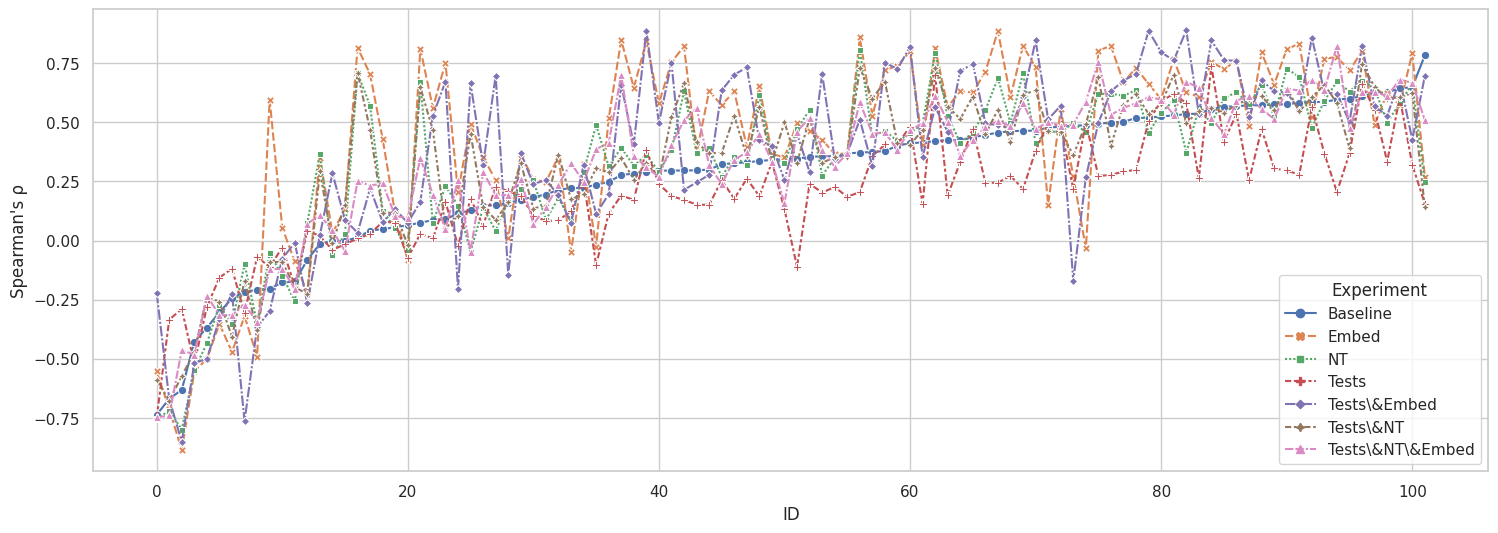

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt

groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]
configs = [
     # ("Base", "all_recordings_feedback_experiment_e60_es15", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    ("Baseline", "all_recordings_feedback_experiment_e60_es15_", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    ("Tests", "all_recordings_feedback_experiment_e60_es15_new_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("NT", "all_recordings_feedback_experiment_e60_es15_new_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Embed", "all_recordings_feedback_experiment_e60_es15_new_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Tests\&Embed", "all_recordings_feedback_experiment_e60_es15_new_depression_tests_embedding", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Tests\&NT", "all_recordings_feedback_experiment_e60_es15_new_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Tests\&NT\&Embed", "all_recordings_feedback_experiment_e60_es15_new_depression_tests_embedding_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
]

predictions_list = []
for name, path, result_base_adjusted in configs:
    _, predictions = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    print(predictions)
    predictions["Experiment"] = name

    predictions_list.append(predictions)

predictions = pd.concat(predictions_list)

predictions = predictions[predictions.patientGroup.isin(groups)]
print(predictions)
if GROUP_BY_DATE:
    num_values = ["true", "prediction"]
    predictions = (
        predictions.groupby(["ID", "Experiment", "date", "patientGroup"])[num_values]
        .mean()
        .reset_index()
    )

predictions = (
    predictions[["ID", "Experiment", "prediction", TRUE]]
    .groupby(["ID", "Experiment"])
    .apply(lambda x: spearmanr(x["prediction"], x[TRUE])[0])
    .dropna()
    .sort_values()
    .sort_index(level="Experiment", sort_remaining=False)
    .reset_index()
)

if GROUP_SEPARATOR == "_":      # TODO make check if speechformer

    predictions_for_avg = predictions

    predictions_for_avg.columns = ["ID", "Experiment", "Spearman's ρ"]
    # nan_rows = predictions_for_avg[predictions_for_avg["Spearman's ρ"].isna()]
    # print(nan_rows)

    # predictions_for_avg = predictions_for_avg[~predictions_for_avg.index.isin(nan_rows.index)]


    ids_in_meta_nt = predictions[predictions['Experiment'] == 'Baseline']['ID'].unique()



    predictions_baseline_avg = predictions_for_avg[
        predictions_for_avg.Experiment == "Baseline"].sort_values(
        by="ID"
    )

    # print(str(predictions_baseline_avg))
    print(len(predictions_baseline_avg))

    print(np.mean(predictions_baseline_avg["Spearman\'s ρ"].values), np.std(predictions_baseline_avg["Spearman\'s ρ"].values))
    print(set(predictions["ID"].values)-set(predictions_baseline_avg["ID"].values))


for name, path, result_base_adjusted in configs:
    predictions_baseline_avg = predictions_for_avg[
        predictions_for_avg.Experiment == name].sort_values(
        by="ID"
    )


predictions["ID"] = pd.factorize(predictions["ID"].values, sort=False)[0]

predictions_hyperformer = predictions[
    predictions.Experiment == "Baseline"
].sort_values(by="ID")

predictions.columns = ["ID", "Experiment", "Spearman's ρ"]
predictions_baseline = predictions[predictions.Experiment == "Baseline"].sort_values(
    by="ID"
)

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ Depression Tests"
].sort_values(by="ID")



predictions_hyperformer.sort_values(by="Spearman's ρ").to_csv("name.csv", index=False)
sns.set_theme(style="whitegrid", rc={"figure.figsize": (18, 6)})
sns.lineplot(
    data=predictions,
    x="ID",
    y="Spearman's ρ",
    hue="Experiment",
    style="Experiment",
    markers=True,
)
predictions_hyperformer.columns = ["ID", "Experiment", "Spearman's ρ"]

# nan_rows = predictions_hyperformer[predictions_hyperformer["Spearman's ρ"].isna()]

# predictions_hyperformer = predictions_hyperformer[~predictions_hyperformer.index.isin(nan_rows.index)]
print(predictions_hyperformer["Spearman\'s ρ"].values)
print(np.mean(predictions_hyperformer["Spearman\'s ρ"].values), np.std(predictions_hyperformer["Spearman\'s ρ"].values))


plt.savefig(f"speaker_performance_{RESULT_FOLDER.split('/')[-1]}_{'_'.join(groups)}.pdf")



In [41]:

table_contents = []
for name, path, result_base_adjusted in configs:
    m, mae = general_metrics_2(path, result_base_adjusted=result_base_adjusted)
    #print(m)
    table_contents.append(f"{name} {print_metrics_2(m, mae)}")
print("\n".join(table_contents))


Baseline  & 0.280\(\pm\)0.057 & 1.593\(\pm\)0.141 & 0.365\(\pm\)0.039 & 1.294\(\pm\)0.231 & 0.166\(\pm\)0.135 & 2.219\(\pm\)0.436 & 0.355\(\pm\)0.094 & 1.360\(\pm\)0.101 \\
Tests  & 0.199\(\pm\)0.068 & 1.218\(\pm\)0.194 & 0.268\(\pm\)0.073 & 0.801\(\pm\)0.240 & 0.132\(\pm\)0.115 & 1.917\(\pm\)0.279 & 0.235\(\pm\)0.071 & 0.998\(\pm\)0.137 \\
NT  & 0.330\(\pm\)0.076 & 1.598\(\pm\)0.101 & 0.399\(\pm\)0.130 & 1.381\(\pm\)0.227 & 0.219\(\pm\)0.144 & 2.116\(\pm\)0.462 & 0.414\(\pm\)0.097 & 1.405\(\pm\)0.120 \\
Embed  & 0.431\(\pm\)0.086 & 1.557\(\pm\)0.266 & 0.523\(\pm\)0.147 & 1.014\(\pm\)0.432 & 0.309\(\pm\)0.159 & 2.521\(\pm\)0.446 & 0.508\(\pm\)0.125 & 1.254\(\pm\)0.167 \\
Tests\&Embed  & 0.365\(\pm\)0.099 & 1.562\(\pm\)0.188 & 0.472\(\pm\)0.146 & 1.152\(\pm\)0.513 & 0.266\(\pm\)0.177 & 2.391\(\pm\)0.554 & 0.412\(\pm\)0.099 & 1.295\(\pm\)0.155 \\
Tests\&NT  & 0.341\(\pm\)0.052 & 1.667\(\pm\)0.165 & 0.438\(\pm\)0.132 & 1.518\(\pm\)0.411 & 0.231\(\pm\)0.132 & 2.130\(\pm\)0.430 & 0.399\(\pm

In [8]:
from sklearn.metrics import mean_squared_error
from itertools import combinations
import numpy as np
import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
from scipy.interpolate import interp1d


def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    x = np.array([float(value) for value in x["Spearman"].values])
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    result = diffsum / (len(x)**2 * np.mean(x))
    return result.tolist()

def gini_2(v, n_new = 1000):
    """Compute Gini coefficient of array of values"""
    v = [float(value) for value in v["Spearman"].values]
    v = (v - np.min(v)) / (np.max(v) - np.min(v))
    v_abs = np.sort(np.abs(v))
    cumsum_v = np.cumsum(v_abs)
    n = len(v_abs)
    vals = np.concatenate([[0], cumsum_v/cumsum_v[-1]])
    x = np.linspace(0, 1, n+1)
    f = interp1d(x=x, y=vals, kind='previous')
    xnew = np.linspace(0, 1, n_new+1)
    dx_new = 1/(n_new)
    vals_new = f(xnew)
    return 1 - 2 * np.trapz(y=vals_new, x=xnew, dx=dx_new)


def calc_gini_index(rmse_values):
    # Sort the rmse_values
    
    rmse_values["Spearman"] = ( rmse_values["Spearman"] - np.min( rmse_values["Spearman"])) / (np.max( rmse_values["Spearman"]) - np.min( rmse_values["Spearman"]))
    rmse_value_help = [float(value) if value > 0 else 0 for value in rmse_values["Spearman"].values]
    numeric_rmse_values =  sorted(rmse_value_help)

    # Calculate the cumulative sums
    cum_values = np.cumsum(numeric_rmse_values)
    sum_values = cum_values[-1]
    cum_indices = np.cumsum(np.arange(1, len(rmse_values) + 1))

    # Calculate the area under the line of perfect equality
    area_equal = np.trapz(cum_indices, dx=1)

    # Calculate the area under the Lorenz curve
    area_lorenz = np.trapz(cum_values, dx=1)

    # Calculate the Gini index
    gini_index = (area_equal - area_lorenz) / area_equal

    return gini_index

def calc_improvements(baseline, new_predictions, offset=1e-6):
    diff = new_predictions["Spearman"].values.squeeze() - baseline["Spearman"].values.squeeze()
    baseline = baseline["Spearman"].values.squeeze()

    improved = diff > 0
    got_worse = diff < 0

    num_improved = np.sum(improved)
    num_got_worse = np.sum(got_worse)

    median_improvement = np.median(diff[improved] / (np.abs(baseline[improved]) + offset))
    median_loss = np.median(diff[got_worse] / (np.abs(baseline[got_worse]) + offset))
    median_improvement_percent = round((1 + median_improvement) * 100, 2)
    median_loss_percent = round(-median_loss * 100, 2)

    return num_improved.tolist(), num_got_worse.tolist(), median_improvement_percent, median_loss_percent
    
predictions_list = []
predictions_base =[]
predictions_adapters = {}


for name, path, result_base_adjusted in configs:

    _, predictions_adapters[name] = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    
    num_values = ["true", "prediction"]

    predictions_adapters[name] = (
        predictions_adapters[name][["ID", "prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .sort_values()
        .sort_index(level="Experiment", sort_remaining=False)
        .reset_index()
    )

gini_index = {}
gini_winners_amount = {}
gini_winners_percent = {}
gini_losers_amount = {}
gini_losers_percent = {}

predictions_help = pd.DataFrame.from_dict(predictions_adapters["Baseline"])
predictions_help.columns = [["ID", "Spearman"]]
predictions_baseline = predictions_help
# print(predictions_help)
baseline_gini_index= gini(predictions_help)
for key in predictions_adapters.keys():
   
    predictions_help = pd.DataFrame.from_dict(predictions_adapters[key])
    predictions_help.columns = [["ID", "Spearman"]]
    
    gini_index[key] = gini(predictions_help)
    gini_winners_amount[key], gini_losers_amount[key],gini_winners_percent[key], gini_losers_percent[key] = calc_improvements(predictions_baseline, predictions_help)

data = {
    "Model": list(gini_index.keys()),
    "Winners Amount": list(gini_winners_amount.values()),
    "Winners Percent": list(gini_winners_percent.values()),
    "Losers Amount": list(gini_losers_amount.values()),
    "Losers Percent": list(gini_losers_percent.values())
}

# Create DataFrame
df = pd.DataFrame(data)

df.fillna('--', inplace=True)

# Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=False)

print(latex_table)

\begin{tabular}{lrlrl}
\toprule
           Model &  Winners Amount & Winners Percent &  Losers Amount & Losers Percent \\
\midrule
        Baseline &               0 &              -- &              0 &             -- \\
           Tests &              17 &          132.81 &             20 &          45.16 \\
              NT &              21 &          124.87 &             16 &          18.16 \\
           Embed &              26 &          145.02 &             11 &          40.42 \\
    Tests\textbackslash \&Embed &              27 &          146.66 &             10 &          35.18 \\
       Tests\textbackslash \&NT &              25 &          120.16 &             12 &          10.97 \\
Tests\textbackslash \&NT\textbackslash \&Embed &              27 &          120.94 &             10 &          19.55 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_790385/1255938257.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = np.array([float(value) for value in x["Spearman"].values])
/tmp/ipykernel_790385/1255938257.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = np.array([float(value) for value in x["Spearman"].values])
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pechleba/miniconda/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.typ

In [28]:

#df, metadata = pyreadstat.read_sav("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/Alle_Daten_bis_t2.sav")
df = pd.read_csv("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/fixed_merged_file.csv")

long_dfs = []
wide_df_2 = df.copy()
groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]



for j, (name, path, result_base_adjusted) in enumerate(configs):
    # _, predictions_hyperformer = load_predictions(path, result_base_adjusted=result_base_adjusted)
    folded_predictions, _ = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    num_values = ["true", "prediction"]
    for i, predictions_hyperformer in folded_predictions.items():
        predictions_hyperformer = (
            predictions_hyperformer.groupby(["ID", "patientGroup"])[num_values]
            .mean()
            .reset_index()
        )
        predictions_hyperformer = predictions_hyperformer[["ID", "prediction", "true"]]
        predictions_hyperformer_long = predictions_hyperformer.copy()
        predictions_hyperformer_long["Experiment"] = name
        predictions_hyperformer_long["fold"] = i
        long_dfs.append(predictions_hyperformer_long)
        if j == 0:
            predictions_hyperformer_long = predictions_hyperformer_long.copy()
            predictions_hyperformer_long["Experiment"] = "Groundtruth"
            predictions_hyperformer_long["prediction"] = predictions_hyperformer_long["true"]
            long_dfs.append(predictions_hyperformer_long)

    # predictions_hyperformer[name] = predictions_hyperformer[0]
    # wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="Code")
long_df = pd.merge(pd.concat(long_dfs), df, left_on="ID", right_on="Code")
print(long_df.columns)




Index(['ID', 'prediction', 'true', 'Experiment', 'fold', 'Code', 'group',
       't1_datum', 't1_state_01', 't1_state_02',
       ...
       'f3_median', 'f4_median', 'nsyll', 'npause', 'dur(s)',
       'phonationtime(s)', 'speechrate(nsyll / dur)',
       'articulation rate(nsyll / phonationtime)', 'ASD(speakingtime / nsyll)',
       'subject'],
      dtype='object', length=669)


In [29]:
from scipy.stats import pearsonr
correlations_dict = {"Experiment": [], "PHQ": [], "HRSD": [], "SEK": [], "Groundtruth": []}

columns_mapping = {
    "PHQ": "t1_phq_sum",
    "HRSD": "t1_HAMD17_ges",
    "SEK": "t1_sek_sum",
    "Groundtruth": "true"
}

def spearman(data):
    d = {}
    for name, column in columns_mapping.items():
        d[name] = spearmanr(data["prediction"].values, data[column].values)[0]
    return pd.Series(d)

def mean_std_string(d):
    metric = f"{np.mean(d.values):.3f}"[1:]
    std = f"{np.std(d.values):.3f}"[1:]
    return f"$ {metric} \pm {std} $"

correlations_table = long_df.fillna(long_df[["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]].mean()).groupby(["Experiment", "fold"]).apply(spearman).groupby("Experiment").agg(mean_std_string)


for experiment in long_df["Experiment"].unique():
    
    _df = long_df[long_df.Experiment == experiment][["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]]
    _df.fillna(_df.mean(), inplace=True)
    correlations_dict["Experiment"].append(experiment)
    correlations_dict["PHQ"].append(spearmanr(_df["prediction"].values, _df["t1_phq_sum"].values)[0])
    correlations_dict["HRSD"].append(spearmanr(_df["prediction"].values, _df["t1_HAMD17_ges"].values)[0])
    correlations_dict["SEK"].append(spearmanr(_df["prediction"].values, _df["t1_sek_sum"].values)[0])
    correlations_dict["Groundtruth"].append(spearmanr(_df["prediction"].values, _df["true"].values)[0])
_df = long_df[long_df.Experiment == "Baseline"][["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]]
_df.fillna(_df.mean(), inplace=True)
correlations_dict["Experiment"].append("Groundtruth")
correlations_dict["PHQ"].append(spearmanr(_df["true"].values, _df["t1_phq_sum"].values)[0])
correlations_dict["HRSD"].append(spearmanr(_df["true"].values, _df["t1_HAMD17_ges"].values)[0])
correlations_dict["SEK"].append(spearmanr(_df["true"].values, _df["t1_sek_sum"].values)[0])
correlations_dict["Groundtruth"].append(spearmanr(_df["true"].values, _df["true"].values)[0])

print(correlations_table.to_latex(float_format="$%.6f$", escape=False))


\begin{tabular}{lllll}
\toprule
{} &                PHQ &               HRSD &                 SEK &        Groundtruth \\
Experiment       &                    &                    &                     &                    \\
\midrule
Baseline         &  $ .328 \pm .180 $ &  $ .261 \pm .109 $ &  $ 0.298 \pm .193 $ &  $ .202 \pm .200 $ \\
Embed            &  $ .217 \pm .132 $ &  $ .156 \pm .142 $ &  $ 0.115 \pm .144 $ &  $ .098 \pm .174 $ \\
Groundtruth      &  $ .653 \pm .077 $ &  $ .578 \pm .172 $ &  $ 0.574 \pm .040 $ &  $ .000 \pm .000 $ \\
NT               &  $ .354 \pm .136 $ &  $ .287 \pm .093 $ &  $ 0.340 \pm .155 $ &  $ .231 \pm .181 $ \\
Tests            &  $ .813 \pm .093 $ &  $ .740 \pm .082 $ &  $ 0.809 \pm .055 $ &  $ .607 \pm .141 $ \\
Tests\&Embed     &  $ .187 \pm .184 $ &  $ .175 \pm .232 $ &  $ 0.123 \pm .199 $ &  $ .097 \pm .235 $ \\
Tests\&NT        &  $ .290 \pm .133 $ &  $ .237 \pm .083 $ &  $ 0.285 \pm .125 $ &  $ .191 \pm .138 $ \\
Tests\&NT\&Embed &  $ .326 \

/tmp/ipykernel_92461/3804038724.py:42: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(correlations_table.to_latex(float_format="$%.6f$", escape=False))


In [19]:
import pyreadstat
df = pd.read_csv("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/merged_file_fixed.csv")

long_dfs = []
wide_df = df.copy()
configs = [
    ("Baseline", "all_recordings_feedback_experimente60_es15_", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    ("Tests", "all_recordings_feedback_experiment_e60_es15_new_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("NT", "all_recordings_feedback_experiment_e60_es15_new_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Embed", "all_recordings_feedback_experiment_e60_es15_new_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Tests\&Embed", "all_recordings_feedback_experiment_e60_es15_new_depression_tests_embedding", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Tests\&NT", "all_recordings_feedback_experiment_e60_es15_new_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Tests\&NT\&Embed", "all_recordings_feedback_experiment_e60_es15_new_depression_tests_embedding_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
]

for name, path, result_base_adjusted in configs:
    _, predictions = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    predictions_hyperformer = (
        predictions[["ID","prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .dropna()
        .sort_values()
        .reset_index()
    )

    predictions_hyperformer_long = predictions_hyperformer.copy()
    predictions_hyperformer_long["Experiment"] = name
    long_dfs.append(predictions_hyperformer_long)
    predictions_hyperformer[name] = predictions_hyperformer[0]
    wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="Code")

long_df = pd.merge(pd.concat(long_dfs), df, left_on="ID", right_on="Code")
long_df["Spearman"] = long_df[0]

/tmp/ipykernel_92461/2062463814.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92461/2062463814.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92461/2062463814.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92461/2062463814.py:22: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92461/2062463814.py:32: FutureWarning: Passing 'suffixes' which cause duplicate columns {'ID_y', '0_y'} in the result is deprecated and will raise a MergeError in a future version.
  wide_df = pd.merge(predict

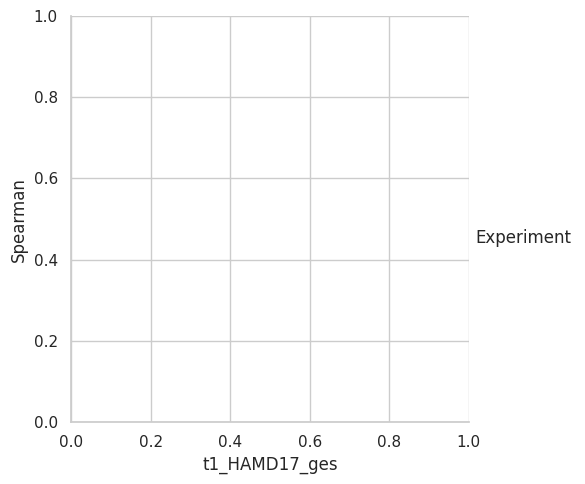

In [20]:
sns.lmplot(data=long_df[(long_df.Experiment.isin(["Baseline", "Hyperformer All", "Hyperformer Reapprasial NT META", "Hyperformer Reapprasial META"])) & (long_df.group.isin([1,2]))], x="t1_HAMD17_ges", y="Spearman", hue="Experiment")

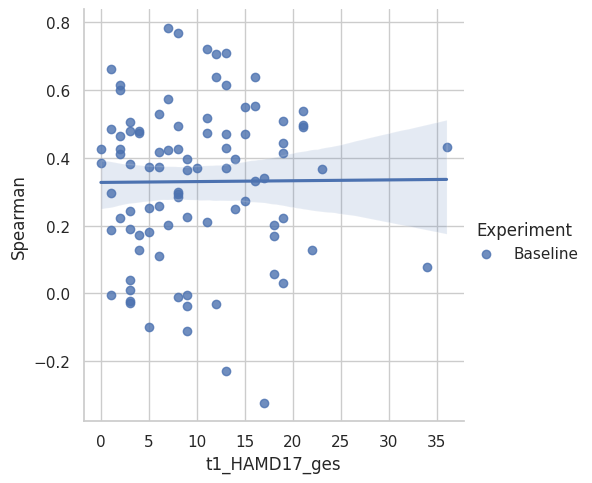

In [ ]:
sns.lmplot(data=long_df[(long_df.Experiment.isin(["Baseline", "Hyperformer All", "Hyperformer Reapprasial NT META", "Hyperformer Reapprasial META"])) & (long_df.group.isin([1,2]))], x="t1_HAMD17_ges", y="Spearman", hue="Experiment")

In [15]:
columns_test = [         "t0_alter",
        "group",
        "Geschlecht",
        "t0_Schulabschluss",
        "t0_Berufsabschluss",
        "t0_Vollzeit",
        "t1_state_01",
        "t1_state_03",
        "t1_state_05",
        "t1_state_07",
        "t1_state_08",
        "t1_state_09",
        "t1_state_10",
        "t1_state_11",
        "t1_state_12",
        "t1_HAMD_01",
        "t1_HAMD_02",
        "t1_HAMD_03",
        "t1_HAMD_04",
        "t1_HAMD_05",
        "t1_HAMD_06",
        "t1_HAMD_07",
        "t1_HAMD_08",
        "t1_HAMD_09",
        "t1_HAMD_10",
        "t1_HAMD_11",
        "t1_HAMD_12",
        "t1_HAMD_13",
        "t1_HAMD_14",
        "t1_HAMD_15",
        "t1_HAMD_16",
        "t1_HAMD_17",
        "t1_HAMD_18",
        "t1_HAMD_19",
        "t1_HAMD_20",
        "t1_HAMD_21",
        "t1_HAMD_22",
        "t1_HAMD_23",
        "t1_HAMD_24",
        "t1_phq_1",
        "t1_phq_2",
        "t1_phq_3",
        "t1_phq_4",
        "t1_phq_5",
        "t1_phq_6",
        "t1_phq_7",
        "t1_phq_8",
        "t1_phq_9",
        "t0_bdi_01",
        "t0_bdi_02",
        "t0_bdi_03",
        "t0_bdi_04",
        "t0_bdi_05",
        "t0_bdi_06",
        "t0_bdi_07",
        "t0_bdi_08",
        "t0_bdi_09",
        "t0_bdi_10",
        "t0_bdi_11",
        "t0_bdi_12",
        "t0_bdi_13",
        "t0_bdi_14",
        "t0_bdi_15",
        "t0_bdi_16",
        "t0_bdi_17",
        "t0_bdi_18",
        "t0_bdi_19",
        "t0_bdi_20",
        "t0_bdi_21",
        "t1_tipi_1",
        "t1_tipi_2",
        "t1_tipi_3",
        "t1_tipi_4",
        "t1_tipi_5",
        "t1_tipi_6",
        "t1_tipi_7",
        "t1_tipi_8",
        "t1_tipi_9",
        "t1_tipi_10",
        "t1_sek_1",
        "t1_sek_2",
        "t1_sek_3",
        "t1_sek_4",
        "t1_sek_5",
        "t1_sek_6",
        "t1_sek_7",
        "t1_sek_8",
        "t1_sek_9",
        "t1_sek_10",
        "t1_sek_11",
        "t1_sek_12",
        "t1_sek_13",
        "t1_sek_14",
        "t1_sek_15",
        "t1_sek_16",
        "t1_sek_17",
        "t1_sek_18",
        "t1_sek_19",
        "t1_sek_20",
        "t1_sek_21",
        "t1_sek_22",
        "t1_sek_23",
        "t1_sek_24",
        "t1_sek_25",
        "t1_sek_26",
        "t1_sek_27",]
columns_nt = [ "meanF0","stdevF0", "localJitter","localAbsoluteJitter",
        "rapJitter",
        "ppq5Jitter",
        "ddpJitter",
        "localShimmer",
        "localdbShimmer",
        "apq3Shimmer",
        "aqpq5Shimmer",
        "apq11Shimmer",
        "ddaShimmer",
        "f1_mean",
        "f2_mean",
        "f3_mean",
        "f4_mean",
        "f1_median",
        "f2_median",
        "f3_median",
        "f4_median",
        "nsyll",
        "npause",
        "dur(s)",
        "phonationtime(s)",
        "speechrate(nsyll / dur)",
        "articulation rate(nsyll / phonationtime)",
        "ASD(speakingtime / nsyll)"]
average_correlations = {}

for name, _, _ in configs:
    correlations = wide_df[columns_test + [name]].corr(method="spearman")

    average_abs_correlation = correlations[name].abs().mean()

    average_correlations[name] = average_abs_correlation

average_correlations_df = pd.DataFrame.from_dict(average_correlations, orient='index', columns=['Average Absolute Correlation'])

print(average_correlations_df.to_latex())

\begin{tabular}{lr}
\toprule
{} &  Average Absolute Correlation \\
\midrule
Baseline         &                      0.133438 \\
Tests            &                      0.089396 \\
NT               &                      0.090330 \\
Embed            &                      0.089482 \\
Tests\textbackslash \&Embed     &                      0.101338 \\
Tests\textbackslash \&NT        &                      0.112870 \\
Tests\textbackslash \&NT\textbackslash \&Embed &                      0.099702 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_92461/406973901.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(average_correlations_df.to_latex())


In [21]:
long_df

,ID,0,Experiment,Code,group,t1_datum,t1_state_01,t1_state_02,t1_state_03,t1_state_04,...,f4_median,nsyll,npause,dur(s),phonationtime(s),speechrate(nsyll / dur),articulation rate(nsyll / phonationtime),ASD(speakingtime / nsyll),subject,Spearman
0,BR0566,-0.738806,Baseline,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.62500,110.496000,4.436847,5.285259,0.189205,NaN,-0.738806
1,BR0566,-0.289368,Tests,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.62500,110.496000,4.436847,5.285259,0.189205,NaN,-0.289368
2,BR0566,-0.799301,NT,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.62500,110.496000,4.436847,5.285259,0.189205,NaN,-0.799301
3,BR0566,-0.886954,Embed,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.62500,110.496000,4.436847,5.285259,0.189205,NaN,-0.886954
4,BR0566,-0.851536,Tests\&Embed,BR0566,2.0,NaN,0.0,-99.0,0.0,-99.0,...,3874.636711,584,31,131.62500,110.496000,4.436847,5.285259,0.189205,NaN,-0.851536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,CB1267,0.456245,NT,CB1267,2.0,NaN,0.0,-99.0,1.0,-99.0,...,3711.463598,537,33,119.12175,100.608875,4.507993,5.337501,0.187354,NaN,0.456245
706,CB1267,0.661827,Embed,CB1267,2.0,NaN,0.0,-99.0,1.0,-99.0,...,3711.463598,537,33,119.12175,100.608875,4.507993,5.337501,0.187354,NaN,0.661827
707,CB1267,0.886761,Tests\&Embed,CB1267,2.0,NaN,0.0,-99.0,1.0,-99.0,...,3711.463598,537,33,119.12175,100.608875,4.507993,5.337501,0.187354,NaN,0.886761
708,CB1267,0.535292,Tests\&NT,CB1267,2.0,NaN,0.0,-99.0,1.0,-99.0,...,3711.463598,537,33,119.12175,100.608875,4.507993,5.337501,0.187354,NaN,0.535292


In [17]:
phq9_columns = ['t1_phq_1', 't1_phq_2', 't1_phq_3', 't1_phq_4', 't1_phq_5', 't1_phq_6', 't1_phq_7', 't1_phq_8', 't1_phq_9', 't1_phq_sum']
hamd_columns = ['t1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't1_HAMD17_ges']
sek_columns = ['t1_sek_1', 't1_sek_2', 't1_sek_3', 't1_sek_4', 't1_sek_5', 't1_sek_6', 't1_sek_7', 't1_sek_8', 't1_sek_9', 't1_sek_10', 't1_sek_11', 't1_sek_12', 't1_sek_13', 't1_sek_14', 't1_sek_15', 't1_sek_16', 't1_sek_17', 't1_sek_18', 't1_sek_19', 't1_sek_20', 't1_sek_21', 't1_sek_22', 't1_sek_23', 't1_sek_24', 't1_sek_25', 't1_sek_26', 't1_sek_27']
sums = ["t1_sek_sum", "t1_phq_sum", "t1_HAMD17_ges", "group"]

In [20]:
print(correlations[sums].loc[[x[0] for x in configs]].to_latex())
latex_output = long_df.style.to_latex()
file_path = '/data/eihw-gpu2/pechleba/results/evaluation/ema_eval.tex'  # You can change the file name and path as needed

# Write the LaTeX output to a .tex file
with open(file_path, 'w') as file:
    file.write(latex_output)
# Compute correlation between sek and std of mood ratings

KeyError: "['t1_sek_sum', 't1_phq_sum', 't1_HAMD17_ges'] not in index"

In [22]:
print(list(correlations.columns))

['t0_alter', 'group', 'Geschlecht', 't0_Schulabschluss', 't0_Berufsabschluss', 't0_Vollzeit', 't1_state_01', 't1_state_03', 't1_state_05', 't1_state_07', 't1_state_08', 't1_state_09', 't1_state_10', 't1_state_11', 't1_state_12', 't1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't1_phq_1', 't1_phq_2', 't1_phq_3', 't1_phq_4', 't1_phq_5', 't1_phq_6', 't1_phq_7', 't1_phq_8', 't1_phq_9', 't0_bdi_01', 't0_bdi_02', 't0_bdi_03', 't0_bdi_04', 't0_bdi_05', 't0_bdi_06', 't0_bdi_07', 't0_bdi_08', 't0_bdi_09', 't0_bdi_10', 't0_bdi_11', 't0_bdi_12', 't0_bdi_13', 't0_bdi_14', 't0_bdi_15', 't0_bdi_16', 't0_bdi_17', 't0_bdi_18', 't0_bdi_19', 't0_bdi_20', 't0_bdi_21', 't1_tipi_1', 't1_tipi_2', 't1_tipi_3', 't1_tipi_4', 't

In [26]:
df["t1_HAMD24_ges"] = df[list(filter(lambda x: "t1_HAMD" in x, list(df.columns)))].apply(lambda x: sum(x), axis=1)

In [29]:
df[["subject", "t1_HAMD17_ges"]].sort_values(by="t1_HAMD17_ges").to_csv("hamd17.csv", index=False)

    subject  group  t1_datum  t1_state_01  t1_state_02  t1_state_03  \
0    AD0941    0.0       NaN          0.0        -99.0          0.0   
1    AE0348    1.0       NaN          0.0        -99.0          1.0   
2    AH0761    1.0       NaN          0.0        -99.0          0.0   
3    AJ0139    0.0       NaN          0.0        -99.0          0.0   
4    AJ1149    0.0       NaN          0.0        -99.0          0.0   
..      ...    ...       ...          ...          ...          ...   
134  UT0462    1.0       NaN          0.0        -99.0          0.0   
135  VA0467    1.0       NaN          0.0        -99.0          0.0   
136  VA0967    1.0       NaN          0.0        -99.0          0.0   
137  VS0276    1.0       NaN          0.0        -99.0          0.0   
138  WH1242    1.0       NaN          0.0        -99.0          1.0   

     t1_state_04  t1_state_05  t1_state_06  t1_state_07  ...    f4_median  \
0          -99.0          0.0        -99.0          2.0  ...  3705.601